<a href="https://colab.research.google.com/github/artbogdanovai/fast_aicourse/blob/master/course/rice/rice_naive_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trying to solve rice competiton
In pure pytorch instead of fast ai

In [1]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.8 MB/s eta 0:00:00


In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import pathlib
import zipfile
import glob
import fastai
from PIL import Image

In [5]:
comp = 'paddy-disease-classification'


In [6]:
creds = '{"username":"artbogdanov","key":"c896dcbee655a8f2bf17e34fc875f65b"}'

In [7]:
if not os.path.exists(os.path.expanduser('~')+'/.kaggle'):
  os.makedirs(os.path.expanduser('~')+'/.kaggle')

In [8]:
with open(os.path.expanduser('~')+'/.kaggle/kaggle.json', 'w') as f:
    f.write(creds)

In [9]:
import kaggle

In [10]:
!ls 

sample_data


In [11]:
path = pathlib.Path(comp)

In [12]:
if not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 1.02G/1.02G [00:07<00:00, 140MB/s]


In [13]:
example = glob.glob(str(path)+'/train_images/downy_mildew/*')[5]

In [14]:
im = Image.open(example)

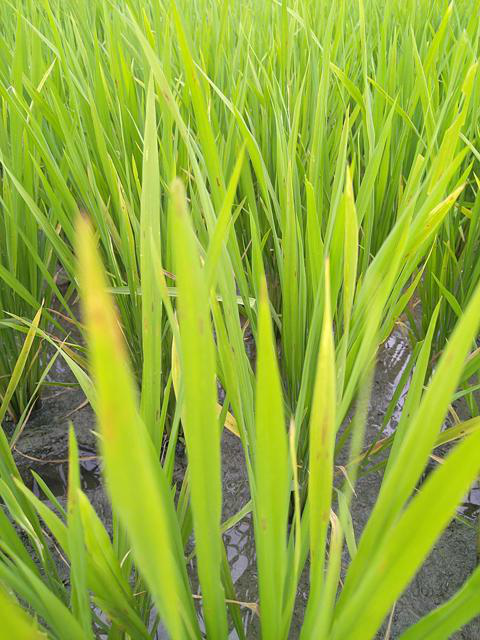

In [15]:
im

In [16]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [17]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
device

device(type='cuda', index=0)

In [18]:
side_size=120

In [19]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize([side_size,side_size]),
     ])
#transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [20]:
dataset = torchvision.datasets.ImageFolder(comp+'/train_images',transform)

In [21]:
dataset

Dataset ImageFolder
    Number of datapoints: 10407
    Root location: paddy-disease-classification/train_images
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=[120, 120], interpolation=bilinear, max_size=None, antialias=None)
           )

In [22]:
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(
    dataset, [train_size, valid_size], 
    generator=torch.Generator().manual_seed(42))

In [23]:
batch_size=16

In [24]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

In [25]:
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                          shuffle=True)

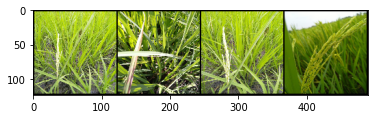

In [26]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
plt.imshow(np.transpose(torchvision.utils.make_grid(images[0:4]), (1, 2, 0)))
plt.show()

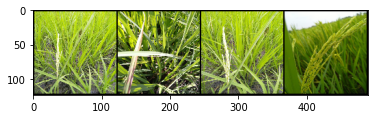

In [27]:
plt.imshow(np.transpose(torchvision.utils.make_grid(images[0:4]), (1, 2, 0)))
plt.show()


In [28]:
images[0].shape

torch.Size([3, 120, 120])

In [29]:
classes = dataset.classes
no_of_classes = len(classes)
classes

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [30]:
no_of_classes

10

In [31]:
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

dead_heart blast dead_heart normal


In [32]:
def calculate_test_accuracy(dataloader):
  total = 0
  correct = 0
  with torch.no_grad():
      for data in dataloader:
          images, labels = data[0].to(device), data[1].to(device)
          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network: {100 * correct // total} %')

In [36]:
size = side_size
pad_size = 1
kern_size = 3
stride_size = 1
pool_size = 2
for i in range(3):
    size = ((size - kern_size + 2 * pad_size) / stride_size + 1) / pool_size
print(size)


15.0


In [48]:
import torch.nn as nn
import torch.nn.functional as F




class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc = nn.Linear(32*15*15, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x,1)
        #print(x.shape)
        x = self.fc(x)
        return x

net = Net()
net = net.to(device)

In [49]:
images.shape

torch.Size([16, 3, 120, 120])

In [50]:
net.forward(images.to(device)).shape

torch.Size([16, 10])

In [51]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [52]:
len(trainloader)

521

In [53]:
%%time
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    correct=0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        with torch.no_grad():
            _, preds = torch.max(outputs.data, 1)
            
            correct += (preds == labels).float().sum()
            #print(preds,labels,(preds == labels).float().sum(),correct)
        running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
    print(f'acc:{correct}, {len(trainloader)*batch_size}, {correct/(len(trainloader)*batch_size)}')
    print(f'test_accuracy:{calculate_test_accuracy(validloader)}')

print('Finished Training')

[1,   521] loss: 0.547
acc:1930.0, 8336, 0.23152589797973633
Accuracy of the network: 34 %
test_accuracy:None
[2,   521] loss: 0.488
acc:2945.0, 8336, 0.3532869517803192
Accuracy of the network: 39 %
test_accuracy:None
[3,   521] loss: 0.454
acc:3363.0, 8336, 0.40343087911605835
Accuracy of the network: 40 %
test_accuracy:None
[4,   521] loss: 0.419
acc:3865.0, 8336, 0.4636516273021698
Accuracy of the network: 50 %
test_accuracy:None
[5,   521] loss: 0.375
acc:4365.0, 8336, 0.5236324071884155
Accuracy of the network: 54 %
test_accuracy:None
[6,   521] loss: 0.328
acc:4948.0, 8336, 0.5935700535774231
Accuracy of the network: 59 %
test_accuracy:None
[7,   521] loss: 0.282
acc:5415.0, 8336, 0.6495921015739441
Accuracy of the network: 62 %
test_accuracy:None
[8,   521] loss: 0.244
acc:5826.0, 8336, 0.6988963484764099
Accuracy of the network: 67 %
test_accuracy:None
[9,   521] loss: 0.209
acc:6215.0, 8336, 0.745561420917511
Accuracy of the network: 69 %
test_accuracy:None
[10,   521] loss: 

In [54]:
%%time
calculate_test_accuracy(trainloader)


Accuracy of the network: 85 %
CPU times: user 1min 1s, sys: 496 ms, total: 1min 2s
Wall time: 1min 2s


In [55]:
%%time
calculate_test_accuracy(validloader)


Accuracy of the network: 72 %
CPU times: user 16.3 s, sys: 119 ms, total: 16.4 s
Wall time: 16.4 s


In [ ]:
PATH = './cifar_net2.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
stop

In [ ]:
model = Net()
model.load_state_dict(torch.load('cifar_net2.pth'))

<All keys matched successfully>

In [ ]:
model.eval()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=460800, out_features=10, bias=True)
)

In [ ]:
model = model.to(device)

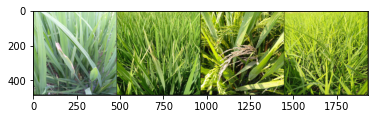

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
plt.imshow(np.transpose(torchvision.utils.make_grid(images[0:4]), (1, 2, 0)))
plt.show()

In [ ]:
with torch.no_grad():
  predictions = model(images.to(device))

In [ ]:
 _, predictions_cat = torch.max(predictions, 1)

In [ ]:
predictions_cat

tensor([3, 6, 5, 8, 5, 8, 7, 5, 8, 1, 9, 7, 5, 0, 5, 7], device='cuda:0')

In [ ]:
#torch.save(model, 'model_architecture.pt')

In [ ]:
[dataset.classes[i] for i in predictions_cat.cpu().numpy()]

['blast',
 'downy_mildew',
 'dead_heart',
 'normal',
 'dead_heart',
 'normal',
 'hispa',
 'dead_heart',
 'normal',
 'bacterial_leaf_streak',
 'tungro',
 'hispa',
 'dead_heart',
 'bacterial_leaf_blight',
 'dead_heart',
 'hispa']

In [ ]:
labels

tensor([3, 6, 5, 8, 5, 8, 7, 5, 8, 1, 9, 7, 5, 0, 5, 7])

In [ ]:
for i in range(16):
  print(f'pred:{dataset.classes[predictions_cat.cpu().numpy()[i]]}, true:{dataset.classes[labels.cpu().numpy()[i]]}')

pred:blast, true:blast
pred:downy_mildew, true:downy_mildew
pred:dead_heart, true:dead_heart
pred:normal, true:normal
pred:dead_heart, true:dead_heart
pred:normal, true:normal
pred:hispa, true:hispa
pred:dead_heart, true:dead_heart
pred:normal, true:normal
pred:bacterial_leaf_streak, true:bacterial_leaf_streak
pred:tungro, true:tungro
pred:hispa, true:hispa
pred:dead_heart, true:dead_heart
pred:bacterial_leaf_blight, true:bacterial_leaf_blight
pred:dead_heart, true:dead_heart
pred:hispa, true:hispa


In [ ]:
calculate_test_accuracy(trainloader)


Accuracy of the network: 95 %


In [ ]:
from torch.utils.data import Dataset

class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image


In [ ]:
im = glob.glob('paddy-disease-classification/test_images/*')[0]

In [ ]:
image = Image.open(im).convert("RGB")

In [ ]:
image = transform(image).to(device)

In [ ]:
image = image.reshape(1,3,480,480)

In [ ]:
with torch.no_grad():
  outputs = net(image)
#_, preds = torch.max(outputs.data, 1)

In [ ]:
outputs

tensor([[ 1.9563, -1.3986, -2.2746, -2.7541,  4.3266,  2.3580, -2.4920,  1.5201,
          1.9879, -2.9253]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
torch.max(outputs.data, 1)[1]

tensor([4], device='cuda:0')

In [ ]:
dataset.classes[torch.max(outputs.data, 1)[1]]

'brown_spot'

In [ ]:
all_images = glob.glob('paddy-disease-classification/test_images/*')

In [ ]:
import pandas as pd

In [ ]:
results = pd.DataFrame(columns = ['image_id','label'])

In [ ]:
i=0
for im in all_images:
    name = im.split('/')[-1]
    image = Image.open(im).convert("RGB")
    image = transform(image).to(device)
    image = image.reshape(1,3,480,480)
    with torch.no_grad():
        outputs = net(image)
    rice_class = dataset.classes[torch.max(outputs.data, 1)[1]]
    results.loc[len(results)] = [name,rice_class]
    i+=1
    if i%500 == 0:
      print(f'500 done {i}')

500 done 500
500 done 1000
500 done 1500
500 done 2000
500 done 2500
500 done 3000


In [ ]:
results.to_csv('submission.csv',index=False)